# Heatmaps for OS frequency and cirrus frequency

Plot 5x5, but take the frequency over the 5x5 box... so divide by time steps AND number of grid points in that box

In [1]:
import sys
sys.path.append("/home/b/b380887/cold-point-overshoot/python_scripts/")
import pickle

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.gridspec import GridSpec


In [2]:
file_path = "/work/bb1153/b380887/global_tropics/"
scratch_path = "/scratch/b/b380887/"

pickle_dir = "/home/b/b380887/cold-point-overshoot/pickle_files/"
save_dir = "/home/b/b380887/cold-point-overshoot/plots/d2_paper_poster/os_ci_freqs/"


In [3]:
model_list = ["OBS", "SCREAM", "GEOS", "SAM", "ICON", "SHIELD"]
model_list_ci = ["OBS", "SCREAM", "GEOS", "SAM", "ICON", "SHIELD"]


In [4]:
sca_coords = [20, 30, -17, -7]
tim_coords = [120, 130, -12, -2]
spc_coords = [170, 180, -15, -5]
amz_coords = [-65, -55, -30, -20]

coords_dict = {
    "SCA": sca_coords,
    "TIM": tim_coords,
    "SPC": spc_coords,
    "AMZ": amz_coords
}


In [5]:
xy_dict = {}

for model in model_list:
    with open(pickle_dir + "cell_counts_5x5/{m}_cell_counts_5x5_dict.pickle".format(m=model), "rb") as handle:
        xy_dict[model] = pickle.load(handle)["xy"]
        

In [7]:
# observations is a lon x lat data array - different counts in each box
xy_dict["OBS_ci"] = xr.open_dataset(file_path + "cirrus_frequencies/4e-6/OBS_xy_5x5_counts_cp.nc")["__xarray_dataarray_variable__"]


In [8]:
xy_dict

{'OBS': 1,
 'SCREAM': 13225,
 'GEOS': 25600,
 'SAM': 17024,
 'ICON': 48400,
 'SHIELD': 28900,
 'OBS_ci': <xarray.DataArray '__xarray_dataarray_variable__' (lon: 72, lat: 8)>
 array([[19061., 19131., 19576., ..., 18810., 18854., 18430.],
        [19337., 18494., 18180., ..., 17249., 19180., 18753.],
        [18259., 18624., 18907., ..., 19770., 18648., 19361.],
        ...,
        [18634., 18801., 18536., ..., 18945., 19708., 19759.],
        [18791., 19729., 20510., ..., 20416., 18410., 18727.],
        [19676., 19267., 18073., ..., 18883., 19273., 19255.]])
 Coordinates:
   * lon      (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
   * lat      (lat) float64 -27.5 -22.5 -17.5 -12.5 -7.5 -2.5 2.5 7.5}

In [7]:
os_dict = {}

for model in model_list:
    out_name = file_path + "os_frequencies/{m}_os_counts_5x5.nc".format(m=model)
    count = xr.open_dataset(out_name)["os_count"]
    if model == "OBS":
        freq = count / 224. / xy_dict[model]
    else:
        freq = count / 240. / xy_dict [model]
    os_dict[model] = freq
    

In [15]:
print("SAM max: {:.8f}%".format(os_dict["SAM"].max().values*100.))

SAM max: 0.00078321%


#### RACP At the cold point level

In [9]:
ci_dict = {}

for model in model_list_ci: 
    out_name = file_path + "cirrus_frequencies/4e-6/{m}_cirrus_counts_5x5_at_zcp.nc".format(m=model)
    count = xr.open_dataset(out_name)["ci_count"]
    if model == "OBS":
        # total count different in each 5x5 box, so divide differently
        freq = count / xy_dict["OBS_ci"]
        # transpose to get lat x lon (match the models)
        ci_dict[model] = freq.T
        
    else:
        freq = count / 240. / xy_dict[model]
        ci_dict[model] = freq
    

#### for obs: try 10x10 (so coarsen 2x2)

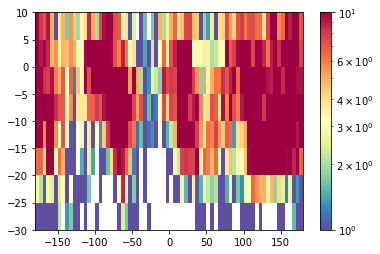

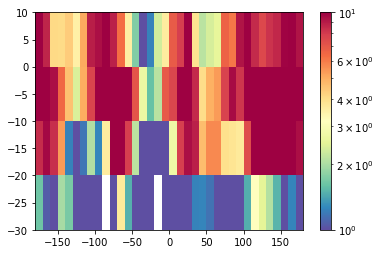

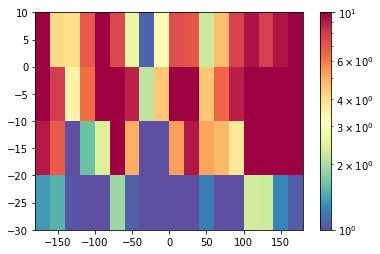

In [17]:
plt.pcolormesh(ci_dict["OBS"].lon, ci_dict["OBS"].lat, ci_dict["OBS"]*100.,
               cmap="Spectral_r", norm=mcolors.LogNorm(vmin=1, vmax=10))
plt.colorbar()
plt.show()

plt.pcolormesh(ci_freq_10x10_obs.lon, ci_freq_10x10_obs.lat, ci_freq_10x10_obs*100.,
               cmap="Spectral_r", norm=mcolors.LogNorm(vmin=1, vmax=10))
plt.colorbar()
plt.show()

plt.pcolormesh(ci_freq_10x20_obs.lon, ci_freq_10x20_obs.lat, ci_freq_10x20_obs*100.,
               cmap="Spectral_r", norm=mcolors.LogNorm(vmin=1, vmax=10))
plt.colorbar()
plt.show()


In [10]:
title_dict = {
    "SAM": "gSAM",
    "SHIELD": "X-SHiELD",
    "ICON": "ICON",
    "GEOS": "GEOS", 
    "SCREAM": "SCREAM",
    "OBS": "Observations (Feb. 2007-2010)"
}


### Plot (together for paper)

In [11]:
def plot_coarse_heatmap_all(freq_dict, model_list, varname, coords_dict, title_dict, cmap="Spectral_r", save_dir=save_dir,
                        mask_min=True, fsize=16, tsize=24, labsize=14, vmin=1, vmax=1e3, figsize=(35, 11), levels=None,
                        central_lon=80, save=False, annotate_regions=False, region_color="k",
                        alpha=1, lognorm=True, cbar_ticks=None, cbar_fmt='%.0f', single_column=False, show_regions=False):
    """Plot the heatmap after it's been calculated
    """
    if varname == "ci":
        longname = "Rad. active cold point cirrus"
    elif varname == "os":
        longname = "Cold point overshoot"
        
    plot_lons = [*np.arange(-100, 181, 40), *np.arange(-140, -99, 40)]
    plot_lats = np.arange(-30, 11, 10)
            
    fig = plt.figure(figsize=figsize)
    
    if single_column:
        gs = GridSpec(7, 6, height_ratios=[1, 1, 1, 1, 1, 1, 0.25], hspace=1, wspace=0.4)
        ax_cp_list = [
            plt.subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=central_lon)),
            plt.subplot(gs[1, :], projection=ccrs.PlateCarree(central_longitude=central_lon)),
            plt.subplot(gs[2, :], projection=ccrs.PlateCarree(central_longitude=central_lon)),
            plt.subplot(gs[3, :], projection=ccrs.PlateCarree(central_longitude=central_lon)),
            plt.subplot(gs[4, :], projection=ccrs.PlateCarree(central_longitude=central_lon)),
            plt.subplot(gs[5, :], projection=ccrs.PlateCarree(central_longitude=central_lon)),
        ]
        ax_cb_cp = plt.subplot(gs[6, 1:5])
    else:
        gs = GridSpec(4, 12, height_ratios=[1, 1, 1, 0.25], hspace=1, wspace=0.4)
        ax_cp_list = [
            plt.subplot(gs[0, :6], projection=ccrs.PlateCarree(central_longitude=central_lon)),
            plt.subplot(gs[0, 6:], projection=ccrs.PlateCarree(central_longitude=central_lon)),
            plt.subplot(gs[1, :6], projection=ccrs.PlateCarree(central_longitude=central_lon)),
            plt.subplot(gs[1, 6:], projection=ccrs.PlateCarree(central_longitude=central_lon)),
            plt.subplot(gs[2, :6], projection=ccrs.PlateCarree(central_longitude=central_lon)),
            plt.subplot(gs[2, 6:], projection=ccrs.PlateCarree(central_longitude=central_lon)),
        ]
        ax_cb_cp = plt.subplot(gs[3, 4:8])


    # -central_lon is an artifical offset to get the plotting longitudes aligned correctly with cartopy & pcolormesh
    for i, model in enumerate(model_list):
        # update - don't convert frequency into %
        freq = freq_dict[model]#*100.
        ax_cp = ax_cp_list[i]
        freq_nz = freq.where(freq > 0)
        
        if model == "ICON" or model == "OBS":
            lons = freq_nz.lon % 360
        else:
            lons = freq_nz.lon
        if lognorm:
            pcm = ax_cp.pcolormesh(lons-central_lon, freq_nz.lat, freq_nz, cmap=cmap,
                               norm=mcolors.LogNorm(vmin=vmin, vmax=vmax), alpha=alpha)
        else:
            pcm = ax_cp.pcolormesh(lons-central_lon, freq_nz.lat, freq_nz, cmap=cmap,
                                   vmin=vmin, vmax=vmax, alpha=alpha)

        # add region borders
        if show_regions:
            for region in list(coords_dict.keys()):
                coords = coords_dict[region]
                ax_cp.add_patch(mpatches.Rectangle(xy=[coords[0], coords[2]], 
                                                width=10, 
                                                height=10,
                                                fill=False, color=region_color, linewidth=5,
                                                transform=ccrs.PlateCarree()
                                               ))        

        # gridlines
        gl = ax_cp.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                            xlocs=plot_lons, ylocs=plot_lats, x_inline=False, y_inline=False, color = "None")
        gl.top_labels = False
        if i in [1, 3, 5] and not single_column:
            gl.left_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': labsize, 'rotation': 0}#20}
        gl.ylabel_style = {'size': labsize}
        ax_cp.add_feature(cfeature.COASTLINE, linewidth=2)
        ax_cp.set_ylim((plot_lats[0], plot_lats[-1]))
        
        # titles
        if model == "OBS" and varname == "os":
            title = "Observations (Feb. 2020)"
        else:
            title = title_dict[model]
        ax_cp.set_title(title, fontsize=tsize)

    # colorbar
    if cbar_ticks is not None:
        cbar_cp = plt.colorbar(pcm, cax=ax_cb_cp, orientation="horizontal", extend="max")#, format=cbar_fmt, ticks=cbar_ticks)
    else:
        cbar_cp = plt.colorbar(pcm, cax=ax_cb_cp, orientation="horizontal", extend="max") #, format=cbar_fmt)
    # cbar_cp.set_label("5°x5° {v} frequency (%)".format(v=longname), fontsize=fsize)
    # cbar_cp.set_label("{v} frequency (%)".format(v=longname), fontsize=fsize)
    cbar_cp.set_label("{v} frequency".format(v=longname), fontsize=fsize)
    cbar_cp.ax.tick_params(labelsize=labsize)
    cbar_cp.ax.tick_params(which="major", length=8)
    cbar_cp.ax.tick_params(which="minor", length=4)

    if save:
        inits = ""
        for model in model_list:
            inits += model[0]
            
        if not lognorm:
            ln = "_linear_colors"
        else:
            ln = ""
        if single_column:
            sc = "_single_col"
        else:
            sc = ""
        if show_regions:
            sr = "_with_regions"
        else:
            sr = ""
            
        plt.savefig(save_dir + "{i}_paper_FREQ_with_cbar_{v}_heatmaps_coarse{n}{s}{r}.png".format(i=inits, n=ln, v=varname, s=sc, r=sr), bbox_inches="tight", dpi=300)
            
    plt.show()


In [12]:
plot_model_list = ["OBS", "ICON", "GEOS", "SAM", "SCREAM", "SHIELD"]


In [13]:
# with corrected ci counts, normal 5x5 coarsened looks fine for obs
plot_ci_dict = ci_dict


#### 6x1

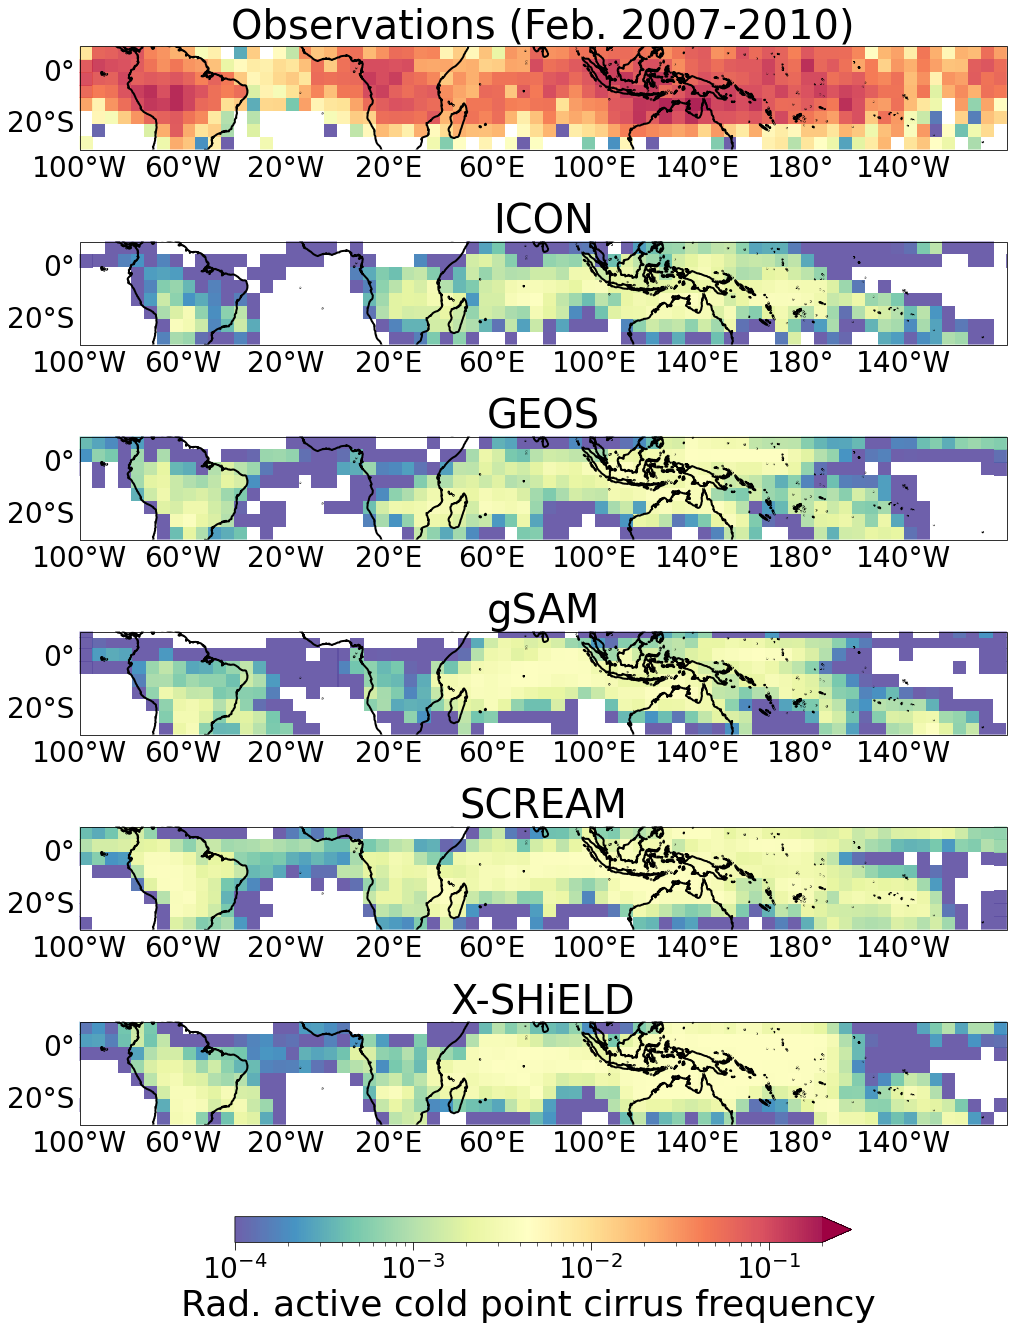

In [19]:
# redo 10/27 - new threshold (4e-6)
plot_coarse_heatmap_all(plot_ci_dict, plot_model_list, "ci", coords_dict, title_dict,
                      labsize=28, fsize=36, tsize=40, region_color="k", alpha=0.9,
                      save=True, cmap="Spectral_r", vmin=(0.01/100.), vmax=(20/100.), 
                      single_column=True, figsize=(17, 22), show_regions=False)


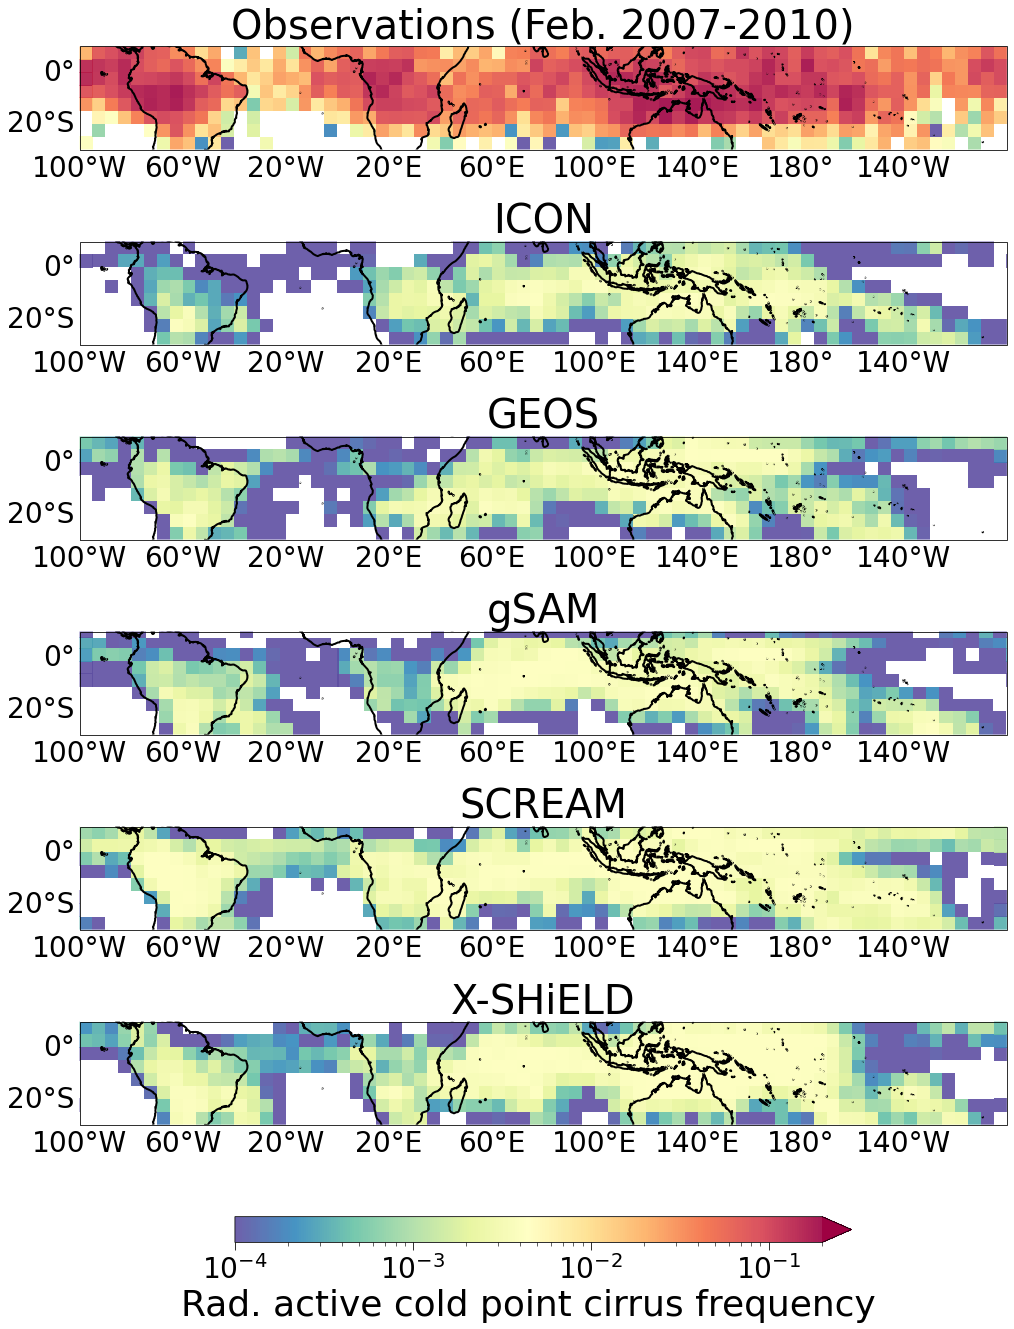

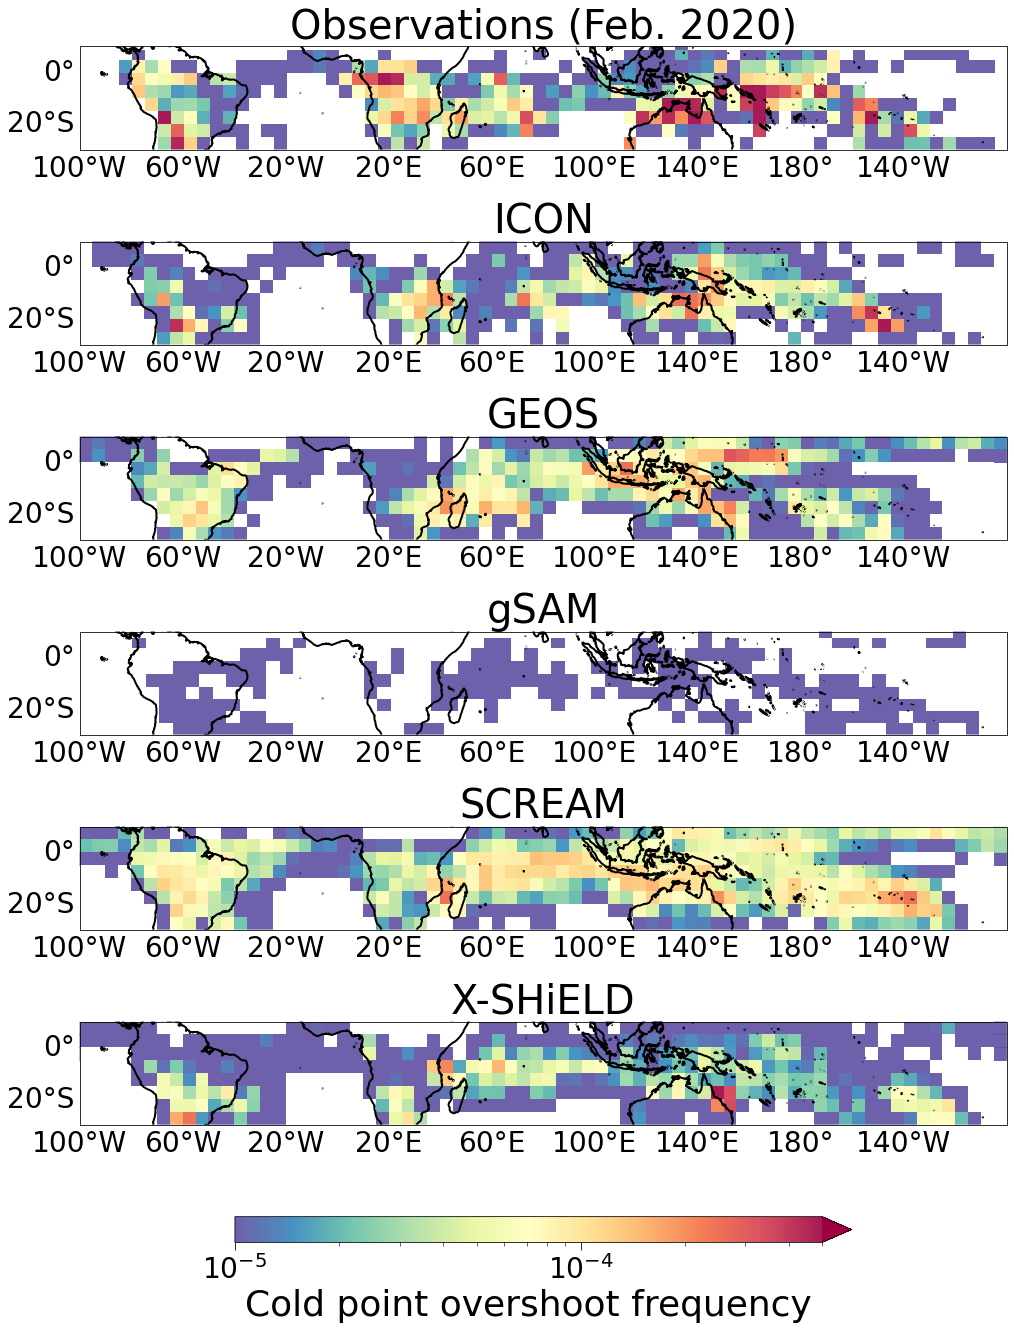

In [15]:
plot_coarse_heatmap_all(plot_ci_dict, plot_model_list, "ci", coords_dict, title_dict,
                      labsize=28, fsize=36, tsize=40, region_color="k", alpha=0.9,
                      save=True, cmap="Spectral_r", vmin=(0.01/100.), vmax=(20/100.), 
                      single_column=True, figsize=(17, 22), show_regions=False)

plot_coarse_heatmap_all(os_dict, plot_model_list, "os", coords_dict, title_dict,
                      labsize=28, fsize=36, tsize=40, region_color="k", alpha=0.9,
                      save=True, cmap="Spectral_r", vmin=(0.001/100.), vmax=(0.05/100.), figsize=(17, 22),
                      cbar_ticks=[0.001, 0.01, 0.05], cbar_fmt='%.3f', single_column=True, show_regions=False)
